## Lab 2: Classification
#### Danny Murphy, Kerry Nakayama, Brandon Tarr

#### Introduction
We've followed a very natural data evolution from Lab 1 where we first started reducing the dataset to a more manageable and relevant size by focusing on bookings only and a five class (rather than 100 class) classification task. In the mini lab we fine-tuned our imputation and started experimenting with logistic regression and SVM classification given the attributes that Expedia provided as well as a handful we created ourselves. Neither of these methods were particularly accurate (~36%) at classifying the targeted hotel cluster so now we turn to three new algorithms to attempt to raise our classification accuracy: AdaBoostClassifier, ExtraTreesClassifier, and RandomForestClassifier. These will also be used to attempt a regression exercise on booking_window (one of our added features) to see if we can predict when a user's ideal search window might be for more targeted solicitation.
#### Sources:
We make extensive use of the code provided for the Grand Poobah Classification Notebook for the class and code from Sebastian Raschka book "Python Machine Learning".

### Data Preparation
We will be conducting one classification task on the hotel cluster which has been the objective of this Kaggle dataset from the outset. This class variable is already in proper format as an integer representation of the five top hotel clusters [0]. All the other features are also in proper format, primarily as either integer representations of categorical variables [1:16] or as numeric continuous variables in either float or integer format [17:25].

#### New Variables
As a reminder, these variables were all added by our team to either contextualize the dates that Kaggle provided or to add more continuous variables in the hopes of adding more explanatory power to the model:

ci_week (check in week) = week of the year (1-52)
srch_week (week that the user's search was conducted) = week of the year (1-52)
family_size = adults + children
booking_window = check in date - search date (number of days booked prior to check in)
length_of_stay = check out date - check in date

In [3]:
#Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
# Reduced, imputed, file.
# Data can be downloaded here: https://www.dropbox.com/s/2vcqmorh3n3cm21/train_booked_top5_imputed.csv?dl=0
train_booked_df = pd.read_csv('data/train_booked_top5_imputed.csv')
train_booked_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
train_booked_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409662 entries, 0 to 409661
Data columns (total 26 columns):
hotel_cluster                409662 non-null int64
site_name                    409662 non-null int64
posa_continent               409662 non-null int64
user_location_country        409662 non-null int64
user_location_region         409662 non-null int64
user_location_city           409662 non-null int64
user_id                      409662 non-null int64
is_mobile                    409662 non-null int64
is_package                   409662 non-null int64
channel                      409662 non-null int64
srch_destination_id          409662 non-null int64
srch_destination_type_id     409662 non-null int64
is_booking                   409662 non-null int64
hotel_continent              409662 non-null int64
hotel_country                409662 non-null int64
hotel_market                 409662 non-null int64
ci_week                      409662 non-null int64
srch_week             

#### Dimensionality Reduction
We've attempted both logistic regression and SVM methods of classification with limited success using all the data that made sense to use without really doing much formal analysis of the utility of each feature. Now we'll spend some time investigating which features we might be able to eliminate to make our models more simple using Sequential Backward Selection (SBS) and random forest techniques.
#### Sequential Backward Selection
Sebastian Raschka's book provides this SBS algorithm code:

In [6]:
from sklearn.base import clone
from itertools import combinations
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

#### Sequential Backward Selection (Continued)
We are using the Logistic Regression model that we determined from the Mini-Lab to be most efficient while acheiving a consistent level of accuracy. While we understand that this model didn't produce good results, the purpose here is to see if we can't maintain the same level of accuracy with fewer features. To improve speed and performance we will be sampling down to around 30,000 records using a stratified shuffle split.

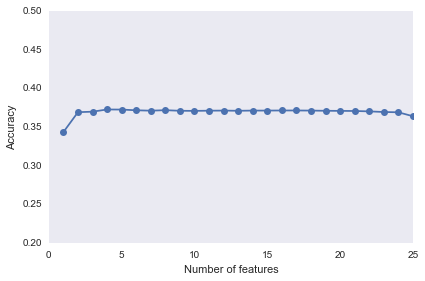

In [61]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler

# we want to predict the X and y data as follows:
# We've put the target as the first attribute to easily assign:
X, y = train_booked_df.iloc[:, 1:].values, train_booked_df.iloc[:, 0].values

# we are sampling way down to improve performance (~30,000 records):
sss = StratifiedShuffleSplit(y, 1, test_size=0.075, train_size=0.075, random_state=0)

for train_index, test_index in sss:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
stdsc = StandardScaler()

#Standardize
X_train_std = stdsc.fit_transform(X_train)

lr = LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs')

# selecting features
sbs_lr = SBS(lr, k_features=1)
sbs_lr.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs_lr.subsets_]

plt.plot(k_feat, sbs_lr.scores_, marker='o')
plt.ylim([0.2, 0.5])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [71]:
# Display individual accuracy scores for each feature subset:
from sets import Set

print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_lr.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_lr.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_lr.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_lr.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.363754719438 , 25 , hotel_market
 1) , 0.368832183309 , 24 , srch_destination_id
 2) , 0.369222757453 , 23 , user_location_region
 3) , 0.370003905741 , 22 , posa_continent
 4) , 0.370524671267 , 21 , srch_week
 5) , 0.370654862648 , 20 , booking_window
 6) , 0.370785054029 , 19 , ci_week
 7) , 0.371045436792 , 18 , srch_destination_type_id
 8) , 0.371175628173 , 17 , is_booking
 9) , 0.371175628173 , 16 , srch_children_cnt
10) , 0.371045436792 , 15 , user_location_city
11) , 0.371045436792 , 14 , cnt
12) , 0.370785054029 , 13 , is_mobile
13) , 0.371045436792 , 12 , srch_rm_cnt
14) , 0.370915245411 , 11 , is_package
15) , 0.370654862648 , 10 , user_id
16) , 0.370785054029 , 9 , family_size
17) , 0.371566202317 , 8 , srch_adults_cnt
18) , 0.370915245411 , 7 , site_name
19) , 0.371436010936 , 6 , channel
20) , 0.372347350605 , 5 , user_location_country
21) , 0.372477541987 , 4 , orig_destination_distance
22) , 0.369

#### Important Features (LR):
We can see in the graph and the scores that a consistent level of accuracy (~37%) can be acheived with either 2 or 24 features with only slightly perceivable dips in between. The most important feature labels are hotel continenent and country followed by length of stay and distance between user and hotel. In the context of poor accuracy scores using logistic regression this tells us that this model is making a reasonable guess just by looking at the hotel continent with marginal gains made from the remainder of the features (pretty much any of them). We don't really like this accuracy or the underlying implications of these data. It makes logical sense that is_booking should lend no explanatory power to the model since we've already cleansed out all non-bookings. However, this feature is not the least important, that distinction going to hotel market instead. Looking at these features in this way helps us understand why logistic regression isn't the best model. Since we'll be moving away from logistic regression in the remainder of this lab, let's apply the same logic for feature importance but use random forests instead.

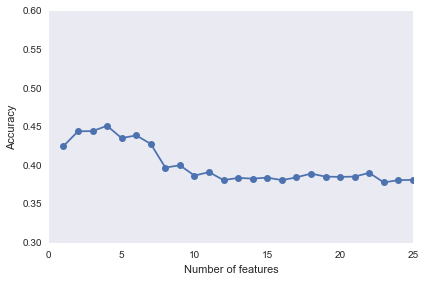

In [64]:
# we are sampling way down to improve performance (~12,000 records):
sss = StratifiedShuffleSplit(y, 1, test_size=0.03, train_size=0.03, random_state=0)

for train_index, test_index in sss:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
stdsc = StandardScaler()

#Standardize
X_train_std = stdsc.fit_transform(X_train)

rf = RandomForestClassifier(max_depth=50, n_estimators=50)

# selecting features
sbs_rf = SBS(rf, k_features=1)
sbs_rf.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs_rf.subsets_]

plt.plot(k_feat, sbs_rf.scores_, marker='o')
plt.ylim([0.3, 0.6])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [70]:
# Display individual accuracy scores for each feature subset:
print("index) , [accuracy] , [feature count] , [feature removed (SBS)] ")

for f in range(X.shape[1]):
    set1 = Set(sbs_rf.subsets_[f])
    if f < X.shape[1] - 1:
        set2 = Set(sbs_rf.subsets_[f + 1])
        k = set1.difference(set2).pop()
    else:
        k = sbs_rf.subsets_[f]
   
    print("%2d) , %-*s , %i , %s" % (f, 10, 
                            sbs_rf.scores_[f], 
                            k_feat[f],
                            train_booked_df.columns[1:][k]))

index) , [accuracy] , [feature count] , [feature removed (SBS)] 
 0) , 0.381386267491 , 25 , srch_children_cnt
 1) , 0.381060852587 , 24 , srch_week
 2) , 0.378132118451 , 23 , length_of_stay
 3) , 0.390497884803 , 22 , family_size
 4) , 0.385616661243 , 21 , user_location_region
 5) , 0.385291246339 , 20 , user_location_country
 6) , 0.385616661243 , 19 , site_name
 7) , 0.389521640091 , 18 , hotel_continent
 8) , 0.384640416531 , 17 , ci_week
 9) , 0.381060852587 , 16 , channel
10) , 0.384315001627 , 15 , user_location_city
11) , 0.383013342011 , 14 , is_package
12) , 0.383989586723 , 13 , is_booking
13) , 0.381060852587 , 12 , cnt
14) , 0.391474129515 , 11 , srch_adults_cnt
15) , 0.386918320859 , 10 , booking_window
16) , 0.400260331923 , 9 , user_id
17) , 0.397331597787 , 8 , orig_destination_distance
18) , 0.427920598763 , 7 , srch_destination_type_id
19) , 0.4389847055 , 6 , is_mobile
20) , 0.435405141555 , 5 , srch_rm_cnt
21) , 0.451350471852 , 4 , posa_continent
22) , 0.4445167

#### Important Features (RF):
We can see in the graph and the scores it's the first 2-7 features that give us the best accuracy results, especially four features which give us the highest accuracy at 45.1%.

In [80]:
k4 = list(sbs_rf.subsets_[21])
print(train_booked_df.columns[1:][k4])

Index([u'posa_continent', u'srch_destination_id', u'hotel_country',
       u'hotel_market'],
      dtype='object')


#### Full model fit:
As a reminder of accuracy performance let's fit using all the features:

In [30]:
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

('Training accuracy:', 0.3645542506156001)
('Test accuracy:', 0.36420001708713218)


In [37]:
# Fitting on 2 features:
lr.fit(X_train_std[:, k2], y_train)
print('Training accuracy:', lr.score(X_train_std[:, k2], y_train))
print('Test accuracy:', lr.score(X_test_std[:, k2], y_test))

('Training accuracy:', 0.36848737829121009)
('Test accuracy:', 0.36689734295094772)


In [38]:
# Fitting on 4 features:
lr.fit(X_train_std[:, k4], y_train)
print('Training accuracy:', lr.score(X_train_std[:, k4], y_train))
print('Test accuracy:', lr.score(X_test_std[:, k4], y_test))

('Training accuracy:', 0.36892981701344707)
('Test accuracy:', 0.36805682691955621)


In [44]:
# Fitting on 12 features:
lr.fit(X_train_std[:, k12], y_train)
print('Training accuracy:', lr.score(X_train_std[:, k12], y_train))
print('Test accuracy:', lr.score(X_test_std[:, k12], y_test))

('Training accuracy:', 0.36831650540538069)
('Test accuracy:', 0.36743436710482957)


In [66]:
# Display individual accuracy scores for each feature subset:
for f in range(X.shape[1]):
    print("%2d) %-*s %i" % (f, 10, 
                            sbs_rf.scores_[f], 
                            k_feat[f]))

 0) 0.369777430691 25
 1) 0.371339320578 24
 2) 0.376024990238 23
 3) 0.372510737993 22
 4) 0.374463100351 21
 5) 0.370167903163 20
 6) 0.374463100351 19
 7) 0.372901210465 18
 8) 0.372120265521 17
 9) 0.372120265521 16
10) 0.377196407653 15
11) 0.368996485748 14
12) 0.374463100351 13
13) 0.375634517766 12
14) 0.369777430691 11
15) 0.372120265521 10
16) 0.384224912144 9
17) 0.376024990238 8
18) 0.388520109332 7
19) 0.38110113237 6
20) 0.384615384615 5
21) 0.442014837954 4
22) 0.437329168294 3
23) 0.430691136275 2
24) 0.426005466615 1


#### Sequential Backward Selection Conclusions:
In the context of logistic regression which we're familiar with from the Mini-Lab, it doesn't seem to influence accuracy much beyond using the hotel continent, country, distance between user and hotel, and length of stay. One could even argue that just continent and country are enough although the test fit does improve with four features. We still don't want to reduce dimensionality based on a 36.8% accuracy rate but let's keep these feature in mind when selecting features with random forests next.
#### Random Forest feature selection:
Since we will be using a couple of variations of random forest algorithms in our classification task let's see what this algorithm's feature_importances function determines to have explanatory power:

 1) hotel_market                   0.107868
 2) srch_destination_id            0.102026
 3) orig_destination_distance      0.097856
 4) user_id                        0.093783
 5) user_location_city             0.087022
 6) srch_week                      0.074021
 7) ci_week                        0.072787
 8) booking_window                 0.071516
 9) user_location_region           0.065946
10) channel                        0.031236
11) length_of_stay                 0.029644
12) hotel_country                  0.025501
13) hotel_continent                0.023168
14) family_size                    0.020228
15) srch_adults_cnt                0.016330
16) srch_destination_type_id       0.016299
17) user_location_country          0.013750
18) site_name                      0.011180
19) srch_children_cnt              0.011137
20) is_mobile                      0.009880
21) srch_rm_cnt                    0.008252
22) posa_continent                 0.004415
23) is_package                  

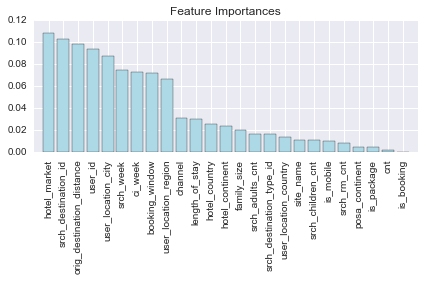

In [46]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = train_booked_df.columns[1:]

forest = RandomForestClassifier(n_estimators=50,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X, y)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

In [14]:
# create variables we are more familiar with
X, y = train_booked_df.iloc[:, 1:].values, train_booked_df.iloc[:, 0].values
yhat = np.zeros(y.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(y, n_folds=10)

# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print 'KNN accuracy', total_accuracy

KNN accuracy 0.233946521767


In [6]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([  9.96469191e-01,   2.30864569e-03,   1.19635238e-03,
         2.44270250e-05,   1.08992267e-06,   2.30603836e-07,
         3.05043813e-08,   1.64981860e-08,   1.19911286e-08,
         2.97305894e-09,   6.84399180e-10,   5.74472370e-10,
         1.10655363e-10,   3.29038898e-11,   2.11866945e-11,
         1.93911665e-11,   8.70510275e-12,   4.81714532e-12,
         1.38650989e-12,   1.24308745e-12,   7.75002266e-13,
         4.81270547e-13,   1.44042436e-13,   6.51527084e-38,
         9.28801703e-45])

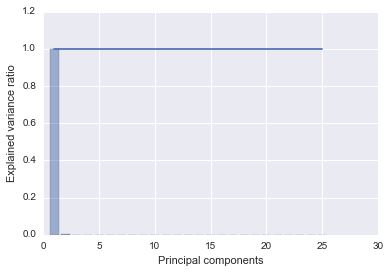

In [9]:
plt.bar(range(1, 26), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 26), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.show()

In [10]:
# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline(
    [('PCA_Expedia',RandomizedPCA(n_components=1)),
     ('CLF_Expedia',KNeighborsClassifier(n_neighbors=1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print 'KNN, pipeline accuracy', total_accuracy

KNN, pipeline accuracy 0.211503629822


In [26]:
clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=5)),
     ('CLF',RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=-1))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy', total_accuracy

Pipeline accuracy 0.397991514956


In [27]:
clf = RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf.fit(X[train],y[train])
    yhat[test] = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Accuracy', total_accuracy

Accuracy 0.455187447213


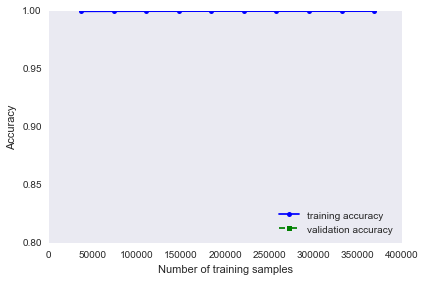

In [17]:
from sklearn.learning_curve import learning_curve
from sklearn.preprocessing import StandardScaler

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=-1, oob_score=True))])

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X,
                               y=y,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

In [ ]:
# now lets get access to the different properties of our RF

print clf

plt.barh(range(len(clf.feature_importances_)), clf.feature_importances_)
plt.show()

print 'Generalization score estimate from training data', clf.oob_score_

In [14]:
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)

# lets train some trees
clf_array = [
    dt_stump,
    AdaBoostClassifier(base_estimator=dt_stump,algorithm="SAMME.R",
                       learning_rate=0.5, n_estimators=50),
    ExtraTreesClassifier(n_estimators=50,min_samples_split=1),
    RandomForestClassifier(max_depth=50, n_estimators=50)
    ]

for clf in clf_array:
    acc = cross_val_score(clf,X,y)
    print acc.mean()

0.368115655377
0.377367175428
0.423207403589
0.447129574609


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn import metrics as mt
from sklearn.decomposition import RandomizedPCA 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.naive_bayes import GaussianNB

In [17]:
# setup pipeline to take PCA, then fit a different classifier
clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=5)),
     ('CLF',GaussianNB())]
)
clf = RandomForestClassifier(max_depth=50, n_estimators=150, n_jobs=-1, oob_score=True)
# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy', total_accuracy

Pipeline accuracy 0.337363485019


In [24]:
from sklearn.neighbors import NearestCentroid


clf_pipe = Pipeline(
    [('PCA',RandomizedPCA(n_components=5)),
     ('CLF',NearestCentroid(metric='euclidean'))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv:
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])
    
total_accuracy = mt.accuracy_score(y, yhat)
print 'Pipeline accuracy', total_accuracy

Pipeline accuracy 0.190320312843


In [25]:
from sklearn import metrics as mt

freq_infreq_threshold = 40

# get various measures of performance
total_accuracy = mt.accuracy_score(y, yhat)

prec_for_freq_classes = []
recall_for_infreq_classes = []
rec_tot = []
prec_tot = []

for cls in np.unique(y):
    idx = (y==cls) # get classes
    ytmp_actual = np.zeros(y.shape) # make binary class problem
    ytmp_actual[idx] = 1 # set the instances for this specific class
    
    ytmp_predicted = np.zeros(y.shape) # binary prediction array
    ytmp_predicted[yhat==cls] = 1
    
    num_in_class = sum(idx)
    
    rec = mt.recall_score(ytmp_actual, ytmp_predicted)
    prec = mt.precision_score(ytmp_actual, ytmp_predicted)
    rec_tot.append(rec)
    prec_tot.append(prec)
    
    if num_in_class < freq_infreq_threshold:
        recall_for_infreq_classes.append(rec)
    elif num_in_class >= freq_infreq_threshold:
        prec_for_freq_classes.append(prec)
        
print 'Total Accuracy:',total_accuracy
print 'Number of infrequent faces:',len(recall_for_infreq_classes), 'with average recall of:', np.mean(recall_for_infreq_classes)
print 'Number of frequent faces:',len(prec_for_freq_classes), 'with average precision of:',np.mean(prec_for_freq_classes)

Total Accuracy: 0.190320312843
Number of infrequent faces: 0 with average recall of: nan
Number of frequent faces: 5 with average precision of: 0.200373769513


/Users/danielmurphy/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
